---
# Formula One race results analysis
B. Gawęda, K. Golemo

---
# Problem formulation

Problem formulation [0-4 pts]:
  - is the problem clearly stated [1 pt]
  - what is the point of creating model, are potential use cases defined [1 pt]
  - where do data comes from, what does it containt [1 pt]
  - is preprocessing step clearly described [1 pt]

In this notebook we tried to create Bayesian multilevel binomial regression model to represent each individual finishing position of each race in years 2017-2021 by separating F1 drivers skills from the advantage of their teams. The point of this model was to create performance ratings for independent components contributing to success. Having these performance ratings for each of the drivers and each of the constructors it is possible to predict race results for any driver-constructor pair (e.g. predict the performance of the worst driver in the best car).

Our data contains a collection of race results (driver name, constructor name, season (year), race number, finishing position and status) for the 2014-2021 Formula 1 seasons from the dataset behind the [Ergast motorsports API](http://ergast.com/mrd/). For our model we only needed information about the driver, his team, position and year in which a race took place. Additionaly we limited the data to 2017-2021 period, as in years 2014 and 2016 there were 22 drivers competing in each race (our model is restricted to positions 1-20). Next step was to unify the team names, as some of them has been modified due to a change of a team owner (for example in choosen period of time name of one team was *Sahara Force India F1 Team*, then *Racing Point Force India F1 Team* and lastly *Aston Martin Aramco Cognizant Formula One Team*). Finally, due to fact that binomial distribution starts from 0, race positions range was rescaled from 1-20 to 0-19. All preprocessing was done in a separate notebook *data_preprocessing.ipynb*.

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Read the data
df = pd.read_csv('data/f1_results.csv')

In [3]:
# Create drivers lookup
drivers_unique = df['driver'].unique()
num_drivers = len(drivers_unique)

drivers_lookup = dict(zip(drivers_unique, range(num_drivers)))
print(drivers_lookup)
drivers = df['driver_code'] = df['driver'].replace(drivers_lookup).values

# Create constructors lookup
constructors_unique = df['constructor'].unique()
num_constructors = len(constructors_unique)

constructors_lookup = dict(zip(constructors_unique, range(num_constructors)))
print(constructors_lookup)
constructors = df['constructor_code'] = df['constructor'].replace(constructors_lookup).values

# Create years lookup
years_unique = df['year'].unique()
num_years = len(years_unique)

years_lookup = dict(zip(years_unique, range(num_years)))
print(years_lookup)
years = df['year_code'] = df['year'].replace(years_lookup).values

{'vettel': 0, 'hamilton': 1, 'bottas': 2, 'raikkonen': 3, 'max_verstappen': 4, 'massa': 5, 'perez': 6, 'sainz': 7, 'kvyat': 8, 'ocon': 9, 'hulkenberg': 10, 'giovinazzi': 11, 'vandoorne': 12, 'alonso': 13, 'kevin_magnussen': 14, 'stroll': 15, 'ricciardo': 16, 'ericsson': 17, 'jolyon_palmer': 18, 'grosjean': 19, 'wehrlein': 20, 'button': 21, 'resta': 22, 'gasly': 23, 'brendon_hartley': 24, 'leclerc': 25, 'sirotkin': 26, 'norris': 27, 'albon': 28, 'russell': 29, 'kubica': 30, 'latifi': 31, 'aitken': 32, 'pietro_fittipaldi': 33, 'tsunoda': 34, 'mick_schumacher': 35, 'mazepin': 36}
{'ferrari': 0, 'mercedes': 1, 'red_bull': 2, 'williams': 3, 'aston_martin': 4, 'alphatauri': 5, 'alpine': 6, 'alfa': 7, 'mclaren': 8, 'haas': 9}
{2017: 0, 2018: 1, 2019: 2, 2020: 3, 2021: 4}


---
# Model

Model [0-4 pts]
  - are two different models specified [1 pt] 
  - are difference between two models explained [1 pt]
  - is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]
  - are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

For each $\mathcal{driver}$ and $\mathcal{constructor}$ in a $\mathcal{year}$, we specify the following multilevel model for the race position $\mathcal{y}$:
$$ y \sim \mathcal{Binomial}(19, \theta)$$



Model 1:
$$ logit(\theta) = \alpha_{driver} + \alpha_{constructor} $$
$$ \alpha_{driver} \sim \mathcal{N}(0, \sigma) $$
$$ \alpha_{constructor} \sim \mathcal{N}(0, \sigma) $$

Model 2:
$$ logit(\theta) = \alpha_{driver} + \alpha_{constructor} + \alpha_{driver, year} + \alpha_{constructor, year} $$
$$ \alpha_{driver} \sim \mathcal{N}(0, \sigma) $$
$$ \alpha_{constructor} \sim \mathcal{N}(0, \sigma) $$
$$ \alpha_{driver, year} \sim \mathcal{N}(0, \sigma) $$
$$ \alpha_{constructor, year} \sim \mathcal{N}(0, \sigma) $$

Model 1 defines $\theta$ as resulting from the average driver skill $\alpha_{driver}$ and the average advantage of the constructor $\alpha_{constructor}$. Model 2 takes into account also the seasonal form of both driver $\alpha_{driver, year}$ and contructor $\alpha_{constructor, year}$.

Interpretation of parameters $\alpha$:
1. $\alpha_{driver}$
    - represents the mean driver skill as a log-odds ratio (most likely race position for $\alpha_{driver}=0.5$ is equal to $19\cdot 1/(1+e^{-0.5}) \cong12$)
    - can be interpreted as a deviaton from the average driver - negative values mean better than average skill, positive mean worse than average skill
2. $\alpha_{constructor}$
    - represents the mean constructor advantage as a log-odds ratio
    - can be interpreted as a deviaton from the average constructor - negative values mean better than average car, positive mean worse than average car
3. $\alpha_{driver, year}$
    - represents yearly deviations from the average driver skill
4. $\alpha_{constructor, year}$
    - represents yearly deviations from the average constructor advantage

---
# Priors (model 1)

Priors [0-4 pts] 
  - Is it explained why particular priors for parameters were selected [1 pt]
  - Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
  - Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
  - How prior parameters were selected [1 pt] 

We decided to choose normal distribution for our alphas, as we can assume, that a driver representing some skill level will always finish somewhere near particular postition, but can sometimes achieve better or worse results due to random events on a track, or just luck. As mean value we selected 0, which in our model means that either driver, or constructor is perfectly mediocre (usually finishing in middle of the stake). We also added some standard deviaton $\sigma$ representing this finishing position randomness stated before.

Due to fact that our alphas don't represent anything we can measure in reality, prior predictive check for all the parameters consists of only visualizating the simulated data for different standard deviations.

Prior predictive check for simulated measurements (finishing position) was performed for different standard deviation of alphas. 

We wanted to get distributions as wide as possible, without an overrepresentation of values on the edges (i.e. for $\theta=0$ or $\theta=1$). During this proces it occured that the best results we got for $\sigma=1$.

In model 2 we use alphas for driver, constructor in general and for each year. Additional alphas expressing their performance in each year were given same priors as in model 1, but with lower standard deviation $\sigma=0.75$ (due to overrepresentation of edge values of $\theta$ for $\sigma=1$). 

In [4]:
model_1_ppc = CmdStanModel(stan_file='stan/model_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [5]:
model_1_ppc_data = {'N': 10, 'sigma': 0.5}
model_1_ppc_sim = model_1_ppc.sample(data=model_1_ppc_data, iter_warmup=0, fixed_param=True, seed=10061011)
df_ppc_sim = model_1_ppc_sim.draws_pd()
df_ppc_sim

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,alpha_driver[1],alpha_driver[2],alpha_driver[3],alpha_driver[4],alpha_driver[5],alpha_driver[6],alpha_driver[7],alpha_driver[8],...,y_ppc[1],y_ppc[2],y_ppc[3],y_ppc[4],y_ppc[5],y_ppc[6],y_ppc[7],y_ppc[8],y_ppc[9],y_ppc[10]
0,0.0,0.0,-0.174340,0.882148,-0.402656,1.501180,-0.702270,0.076820,0.666079,0.586993,...,11.0,8.0,6.0,18.0,8.0,9.0,11.0,15.0,13.0,11.0
1,0.0,0.0,-0.247113,0.970606,0.681812,0.233540,0.921734,0.271197,-0.197660,0.631548,...,8.0,15.0,12.0,11.0,15.0,9.0,7.0,13.0,14.0,4.0
2,0.0,0.0,-0.241763,-0.360831,-0.435422,-0.614468,-0.003758,-0.046564,0.809586,-0.043868,...,7.0,9.0,9.0,3.0,9.0,9.0,8.0,13.0,16.0,15.0
3,0.0,0.0,-0.455596,0.100753,1.315980,-0.454405,0.789700,0.132289,-0.371665,-0.496041,...,10.0,10.0,13.0,5.0,13.0,7.0,4.0,5.0,9.0,9.0
4,0.0,0.0,0.458704,-0.869815,-0.172960,0.192301,-0.379664,0.373183,-0.074329,0.520579,...,10.0,0.0,14.0,8.0,4.0,11.0,2.0,14.0,9.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,-0.059762,0.165464,-0.333780,-0.130891,0.102485,0.908758,-0.646554,0.119035,...,9.0,8.0,3.0,9.0,8.0,16.0,9.0,8.0,11.0,4.0
996,0.0,0.0,-0.134228,0.207598,0.100218,-0.557334,-0.037628,-0.729114,0.605768,0.313560,...,11.0,11.0,6.0,9.0,9.0,4.0,17.0,15.0,12.0,10.0
997,0.0,0.0,0.362887,0.188227,0.095303,0.065083,-0.502408,-0.174772,0.524232,0.690036,...,18.0,10.0,9.0,12.0,5.0,10.0,6.0,12.0,9.0,5.0
998,0.0,0.0,-0.162257,0.486294,0.253968,0.028018,0.938634,0.458175,0.237922,0.434800,...,9.0,9.0,14.0,7.0,9.0,12.0,13.0,8.0,11.0,6.0


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


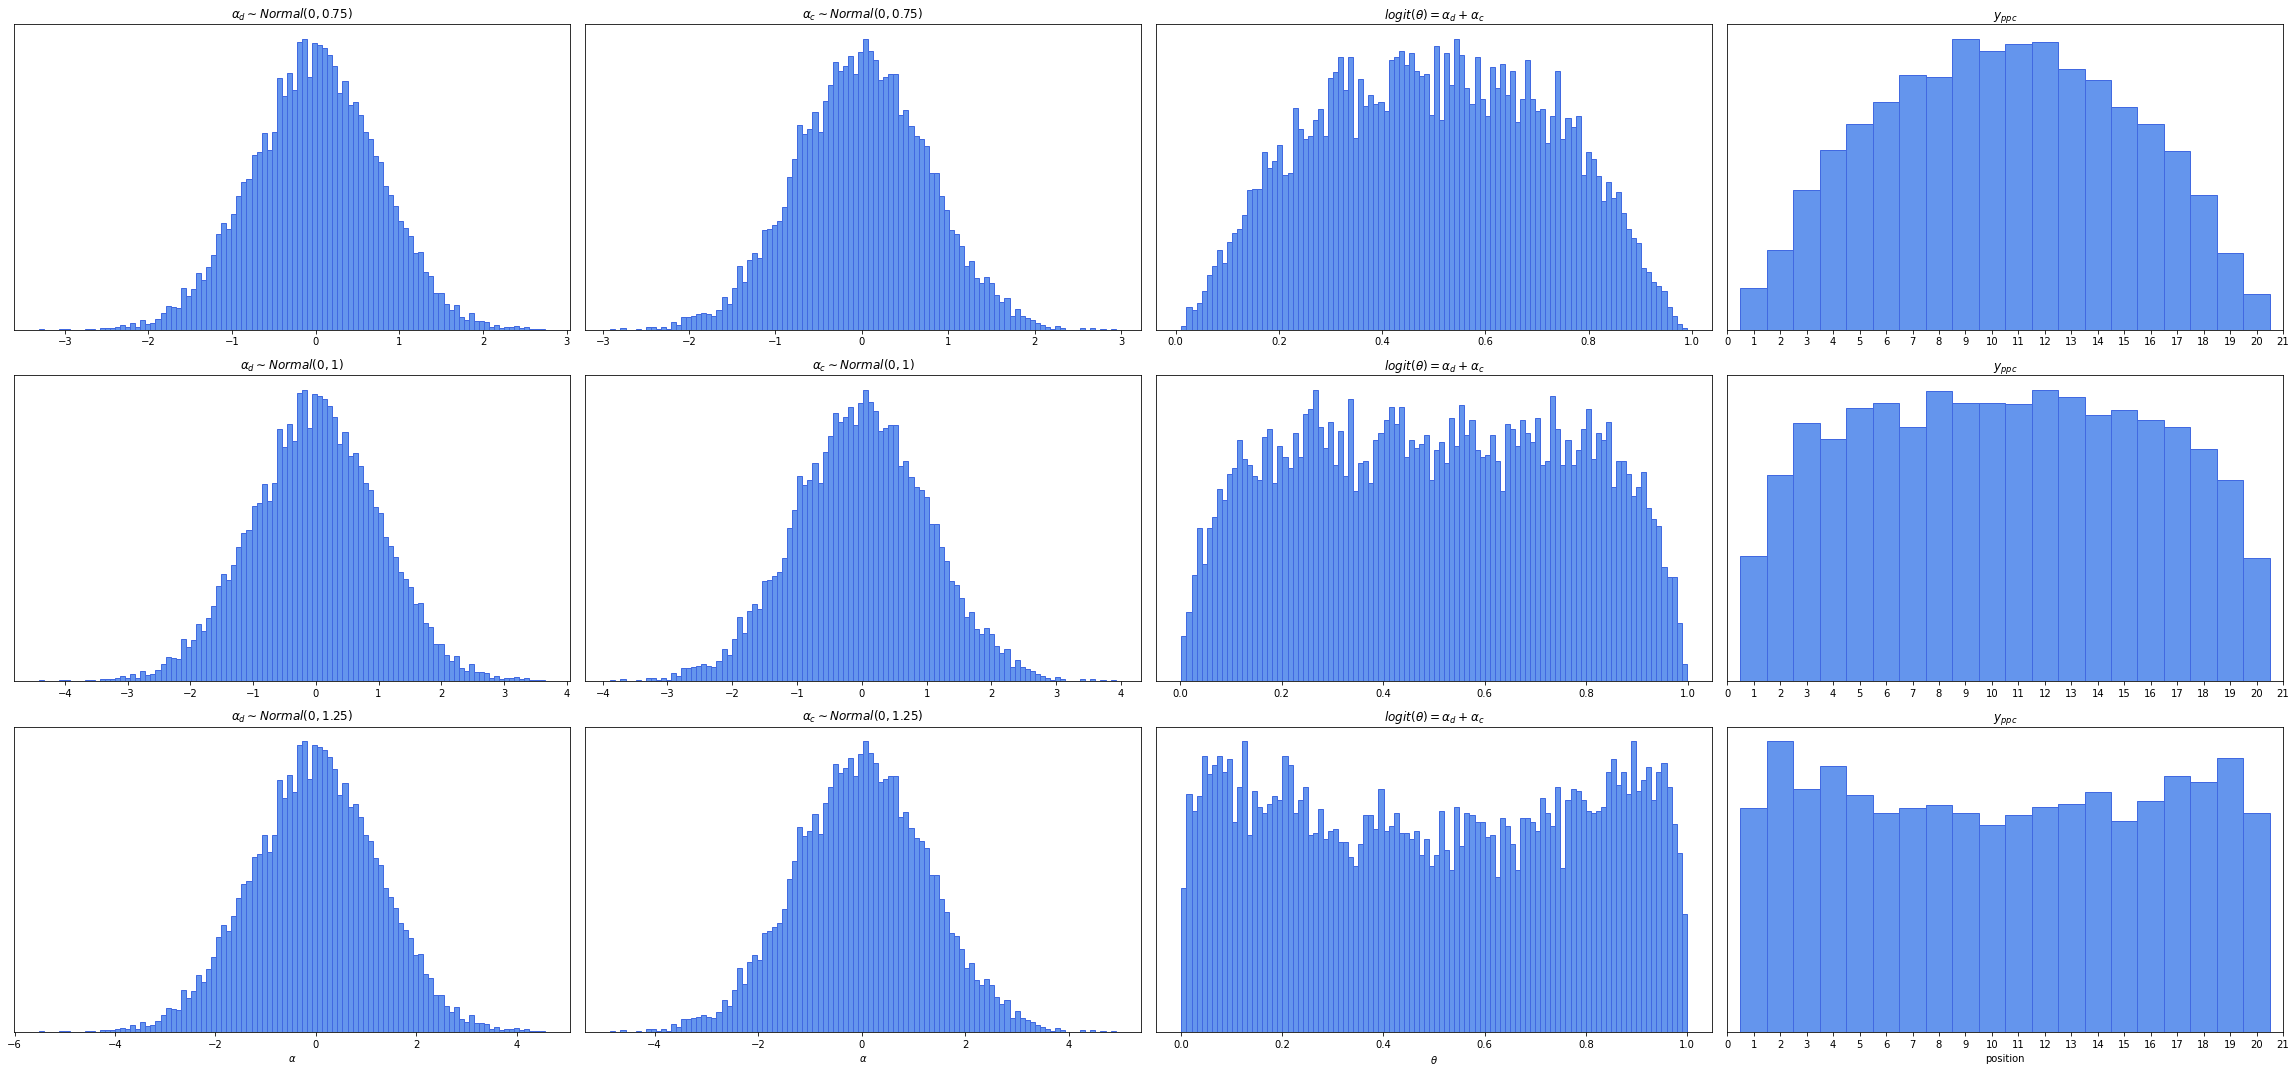

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(8*4, 15))

sigmas = [0.75, 1, 1.25]
limits = [1, 2, 3]

for s_i in range(3):
    model_1_ppc_data['sigma'] = sigmas[s_i]
    model_1_ppc_sim = model_1_ppc.sample(data=model_1_ppc_data, iter_warmup=0, fixed_param=True, seed=10062022)
    axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 0].set_yticks([])
    axes[s_i, 0].set_title(r'$\alpha_d\sim Normal(0,{})$'.format(sigmas[s_i]))
    # x = np.linspace(-limits[s_i], limits[s_i])
    # y = stats.norm.pdf(x, loc=0, scale=sigmas[s_i])
    # axes[s_i, 0].plot(x, y, color='black', linewidth=2)

    axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('alpha_constructor').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 1].set_yticks([])
    axes[s_i, 1].set_title(r'$\alpha_c\sim Normal(0,{})$'.format(sigmas[s_i]))
    # axes[s_i, 1].plot(x, y, color='black', linewidth=2)

    axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 2].set_yticks([])
    axes[s_i, 2].set_title(r'$logit(\theta) = \alpha_d + \alpha_c$')
    
    # pos_min = 1, pos_max = 20
    n_bins = np.arange(22) - 0.5
    axes[s_i, 3].hist(model_1_ppc_sim.stan_variable('y_ppc').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 3].set_xticks(range(22))
    axes[s_i, 3].set_xlim([0, 21])
    axes[s_i, 3].set_yticks([])
    axes[s_i, 3].set_title(r'$y_{ppc}$')

axes[2, 0].set_xlabel(r'$\alpha$')
axes[2, 1].set_xlabel(r'$\alpha$')
axes[2, 2].set_xlabel(r'$\theta$')
axes[2, 3].set_xlabel(r'position')

fig.tight_layout()
plt.show()

As stated above, best results were acheived for $\sigma$=1, as the distribution for $\theta$ is wide and the overrepresentation of edge values didn't occure.

---
# Priors (model 2)

In [7]:
model_2_ppc = CmdStanModel(stan_file='stan/model_2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
model_2_ppc_data = {'N': 10, 'sigma': 0.5}
model_2_ppc_sim = model_2_ppc.sample(data=model_2_ppc_data, iter_warmup=0, fixed_param=True, seed=10062022)
df_ppc_sim = model_2_ppc_sim.draws_pd()
df_ppc_sim

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,alpha_driver[1],alpha_driver[2],alpha_driver[3],alpha_driver[4],alpha_driver[5],alpha_driver[6],alpha_driver[7],alpha_driver[8],...,y_ppc[1],y_ppc[2],y_ppc[3],y_ppc[4],y_ppc[5],y_ppc[6],y_ppc[7],y_ppc[8],y_ppc[9],y_ppc[10]
0,0.0,0.0,-0.435920,-0.049666,-0.234938,0.528999,0.013667,-0.610855,-0.163343,-0.377636,...,8.0,9.0,12.0,5.0,12.0,3.0,10.0,5.0,9.0,17.0
1,0.0,0.0,-0.302026,0.530536,-0.469669,0.098967,-0.300017,0.291127,-0.193973,0.415530,...,5.0,15.0,11.0,8.0,6.0,15.0,14.0,11.0,12.0,7.0
2,0.0,0.0,1.105990,0.560980,-0.200056,-0.041846,-0.845510,-0.634633,0.128950,-0.124437,...,5.0,15.0,3.0,14.0,2.0,10.0,15.0,14.0,6.0,11.0
3,0.0,0.0,0.157386,-0.234268,-0.098636,-0.078676,0.732790,0.068445,-0.520897,-0.734800,...,10.0,13.0,6.0,16.0,12.0,15.0,5.0,5.0,18.0,17.0
4,0.0,0.0,0.102751,-0.015763,1.375400,0.014557,0.172795,-0.447717,0.144769,0.237150,...,6.0,1.0,16.0,11.0,11.0,3.0,4.0,8.0,11.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.617924,0.614961,-0.760670,0.529271,0.251564,-0.264822,0.763551,0.446679,...,17.0,6.0,2.0,13.0,16.0,4.0,12.0,15.0,7.0,3.0
996,0.0,0.0,-0.083533,-1.326780,0.244873,-0.262971,0.765183,0.454654,-0.085469,0.081726,...,11.0,12.0,4.0,15.0,14.0,15.0,10.0,9.0,6.0,14.0
997,0.0,0.0,-0.423236,0.027463,0.303581,0.225418,-0.127243,0.182673,0.841923,-0.307152,...,2.0,9.0,8.0,14.0,12.0,8.0,14.0,15.0,7.0,6.0
998,0.0,0.0,-1.365370,0.211536,0.702549,-0.710541,-0.070195,0.567854,-0.091663,0.271465,...,6.0,8.0,9.0,7.0,10.0,19.0,7.0,16.0,17.0,1.0


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


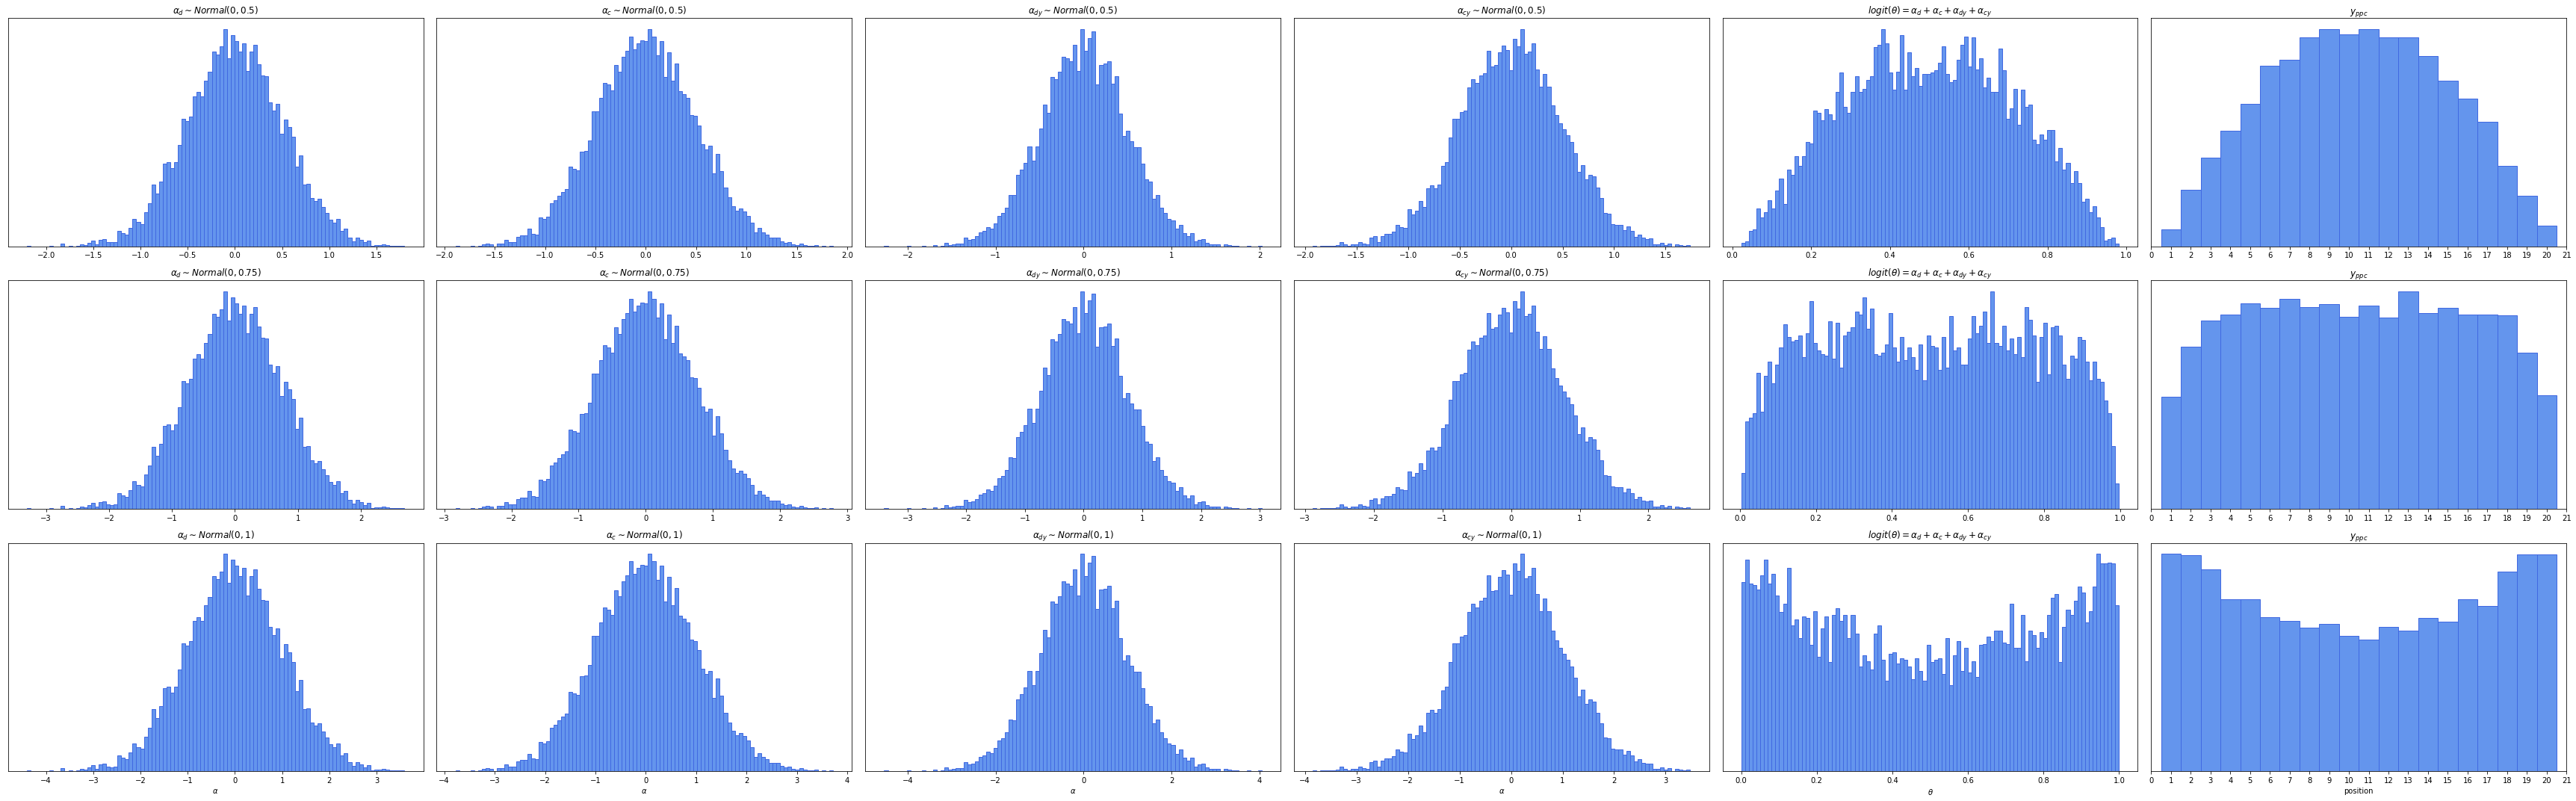

In [9]:
fig, axes = plt.subplots(3, 6, figsize=(8*6, 15))

sigmas = [0.5, 0.75, 1]
limits = [1, 2, 3]

for s_i in range(3):
    model_2_ppc_data['sigma'] = sigmas[s_i]
    model_2_ppc_sim = model_2_ppc.sample(data=model_2_ppc_data, iter_warmup=0, fixed_param=True, seed=10062022)
    axes[s_i, 0].hist(model_2_ppc_sim.stan_variable('alpha_driver').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 0].set_yticks([])
    axes[s_i, 0].set_title(r'$\alpha_d\sim Normal(0,{})$'.format(sigmas[s_i]))
    # x = np.linspace(-limits[s_i], limits[s_i])
    # y = stats.norm.pdf(x, loc=0, scale=sigmas[s_i])
    # axes[s_i, 0].plot(x, y, color='black', linewidth=2)

    axes[s_i, 1].hist(model_2_ppc_sim.stan_variable('alpha_constructor').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 1].set_yticks([])
    axes[s_i, 1].set_title(r'$\alpha_c\sim Normal(0,{})$'.format(sigmas[s_i]))
    # axes[s_i, 1].plot(x, y, color='black', linewidth=2)

    axes[s_i, 2].hist(model_2_ppc_sim.stan_variable('alpha_driver_year').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 2].set_yticks([])
    axes[s_i, 2].set_title(r'$\alpha_{dy}\sim$' + r'$Normal(0,{})$'.format(sigmas[s_i]))
    # axes[s_i, 2].plot(x, y, color='black', linewidth=2)

    axes[s_i, 3].hist(model_2_ppc_sim.stan_variable('alpha_constructor_year').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 3].set_yticks([])
    axes[s_i, 3].set_title(r'$\alpha_{cy}\sim$' + r'$Normal(0,{})$'.format(sigmas[s_i]))
    # axes[s_i, 3].plot(x, y, color='black', linewidth=2)

    axes[s_i, 4].hist(model_2_ppc_sim.stan_variable('theta').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 4].set_yticks([])
    axes[s_i, 4].set_title(r'$logit(\theta) = \alpha_d + \alpha_c + \alpha_{dy} + \alpha_{cy}$')
    
    # pos_min = 1, pos_max = 20
    n_bins = np.arange(22) - 0.5
    axes[s_i, 5].hist(model_2_ppc_sim.stan_variable('y_ppc').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 5].set_xticks(range(22))
    axes[s_i, 5].set_xlim([0, 21])
    axes[s_i, 5].set_yticks([])
    axes[s_i, 5].set_title(r'$y_{ppc}$')

axes[2, 0].set_xlabel(r'$\alpha$')
axes[2, 1].set_xlabel(r'$\alpha$')
axes[2, 2].set_xlabel(r'$\alpha$')
axes[2, 3].set_xlabel(r'$\alpha$')
axes[2, 4].set_xlabel(r'$\theta$')
axes[2, 5].set_xlabel(r'position')

fig.tight_layout()
plt.show()

As stated above, best results were acheived for $\sigma$=0.75, as the distribution of $\theta$ is wide and the overrepresentation of edge values didn't occure.

---
# Posterior analysis (model 1)

Posterior analysis (model 1) [0-4 pts] 
  - were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
  - are the samples from posterior predictive distribution analyzed [1 pt]
  - are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
  - have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]  

There were no issues during sampling.

In [10]:
model_1 = CmdStanModel(stan_file='stan/model_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [11]:
model_1_data = {'N': len(df),
                'D': len(drivers_lookup),
                'C': len(constructors_lookup),
                'driver': drivers+1,
                'constructor': constructors+1,
                'position': df['position']}

model_1_fit = model_1.sample(data=model_1_data, seed=10062022)
print(model_1_fit.diagnose())

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:07 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:10 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:12 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:15 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:17 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:20 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:22 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:24 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:27 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:31 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:35 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:39 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  |


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_1-20220621125621_1.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_1-20220621125621_2.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_1-20220621125621_3.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_1-20220621125621_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## Posterior predictive

Posterior predictive samples are quite consistent with observed data, but there are some issues related to the fact that in Formula 1 there is no guarantee that a driver will finish the race (because of an accident or any breakdown) - even those who usually finish first sometimes finish around place 20. 
For example Max Verstappen usually finished inside the top 5, but sometimes due to some issues with the car he dropped to bottom 5. Our binomial distribution represents this information by dragging mean racing position towards the end and not capturing bimodal observed finishing positions distribution. 

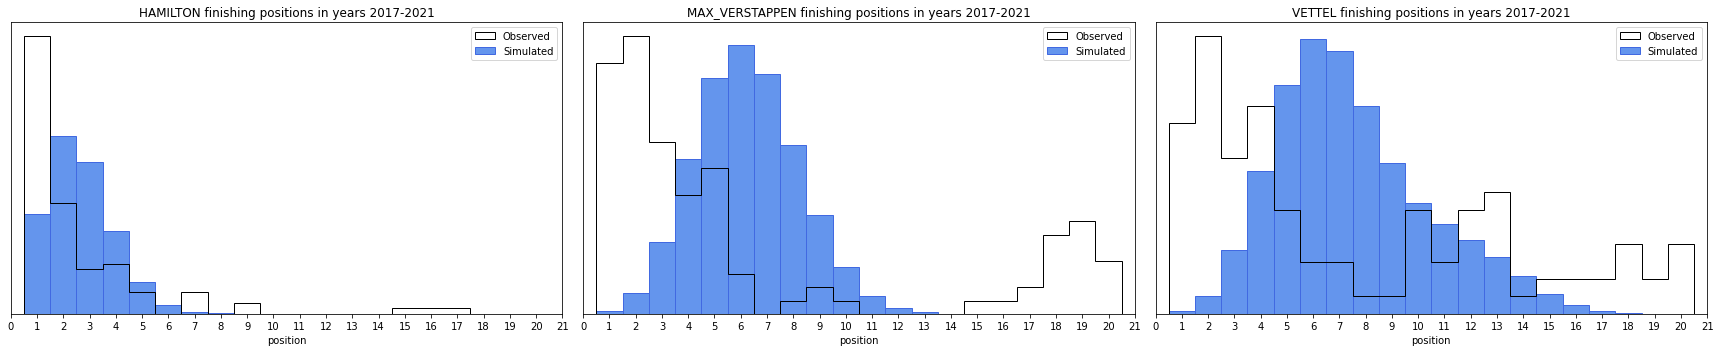

In [12]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# pos_min = 1, pos_max = 20
n_bins = np.arange(22) - 0.5

# year = 2017
# y_lookup_i = years_lookup[year]
drivers_names = ['hamilton', 'max_verstappen', 'vettel']
for d_i, d_name in enumerate(drivers_names):
    d_lookup_i = drivers_lookup[d_name]
    # results = df[(df['driver'] == d_name) & (df['year'] == year)]
    results = df[df['driver'] == d_name]
    axes[d_i].hist((results['position']+1).tolist(), bins=n_bins, rwidth=1, histtype='step', edgecolor='black', density=True, label='Observed')
    results_idx = results.index
    axes[d_i].hist(model_1_fit.stan_variable('y_hat').T[results_idx].flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True, label='Simulated')
    axes[d_i].set_xticks(range(22))
    axes[d_i].set_xlim([0, 21])
    axes[d_i].set_yticks([])
    axes[d_i].set_title(d_name.upper() + ' finishing positions in years 2017-2021')
    axes[d_i].legend()
    axes[d_i].set_xlabel(r'position')

fig.tight_layout()
plt.show()

## Parameters

If we compare $\alpha_{d}$ for each drivers, it is clearly visible that our model corectly recognize quality of a driver - below we ploted parameters for Hamilton (one of the best drivers), Perez (average driver) and Stroll (he pays to drive which means that he is really bad). After calculating mean of all parameters for each driver, Hamilton has lowest, and Stroll has highest parameter alpha (the lower parameter - the better).

Same analysis was conducted for constructors - Mercedes as one of the best constructor has the lowest parameter $\alpha_{c}$ and Haas as one of the worst - the highest.

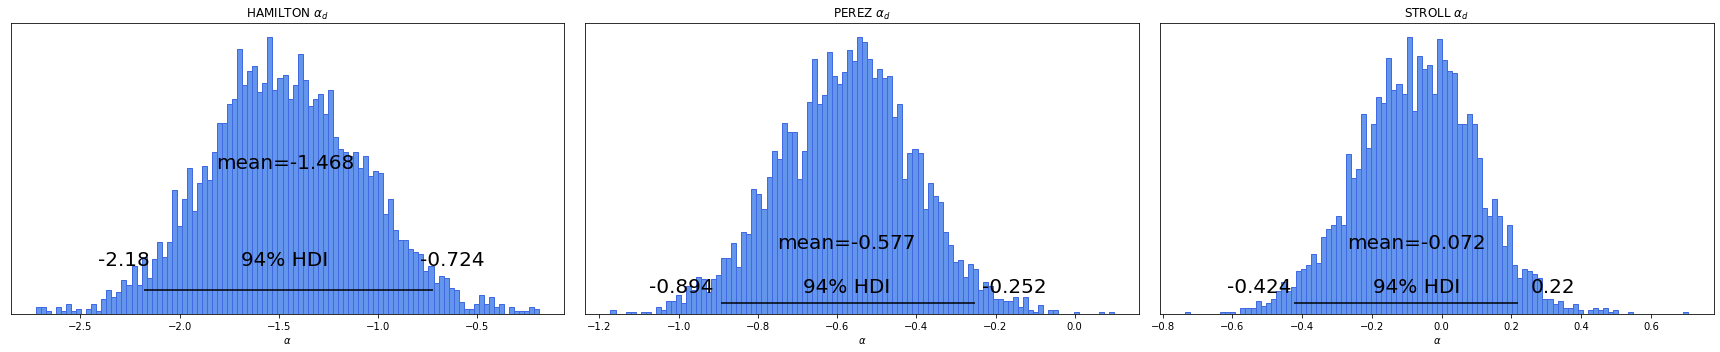

In [13]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

drivers_names = ['hamilton', 'perez', 'stroll']
x = np.linspace(0, 4000, 4000)

statistics = az.summary(model_1_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.94)
for d_i, d_name in enumerate(drivers_names):
    # axes[d_i].scatter(x, model_1_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]], color='royalblue', s=1)
    hdi_l = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'hdi_3%']
    hdi_h = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'hdi_97%']
    mean = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'mean']
    axes[d_i].hist(model_1_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]].flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[d_i].hlines(y=0.1, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[d_i].annotate(str(hdi_l), xy=(hdi_l-0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate(str(hdi_h), xy=(hdi_h+0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate('94% HDI', xy=(mean, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate(f'mean={mean}', xy=(mean, 0.6), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].set_yticks([])
    # axes[d_i].hlines(model_1_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]].mean(), xmin=0, xmax=4000, color='royalblue', linewidth=2)
    axes[d_i].set_title(d_name.upper() + r' $\alpha_d$')
    axes[d_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

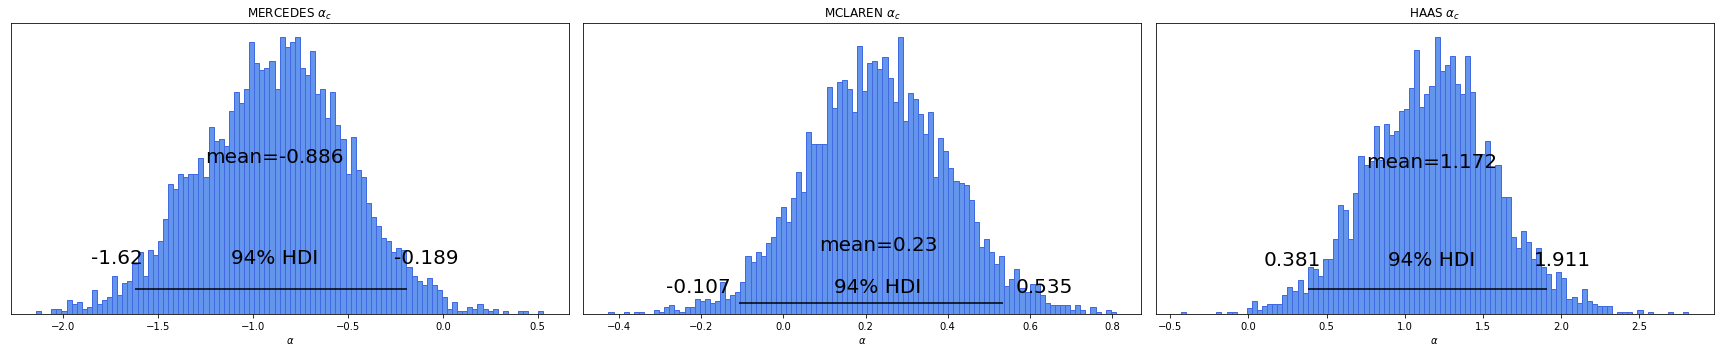

In [14]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

constructors_names = ['mercedes', 'mclaren', 'haas']
x = np.linspace(0, 4000, 4000)

statistics = az.summary(model_1_fit, var_names=['alpha_constructor'], kind='stats', hdi_prob=.94)
for c_i, c_name in enumerate(constructors_names):
    # axes[c_i].scatter(x, model_1_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]], color='royalblue', s=1)
    hdi_l = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'hdi_3%']
    hdi_h = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'hdi_97%']
    mean = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'mean']
    axes[c_i].hist(model_1_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]].flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[c_i].hlines(y=0.1, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[c_i].annotate(str(hdi_l), xy=(hdi_l-0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate(str(hdi_h), xy=(hdi_h+0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate('94% HDI', xy=(mean, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate(f'mean={mean}', xy=(mean, 0.6), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].set_yticks([])
    # axes[c_i].hlines(model_1_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]].mean(), xmin=0, xmax=4000, color='royalblue', linewidth=2)
    axes[c_i].set_title(c_name.upper() + r' $\alpha_c$')
    axes[c_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

---
# Posterior analysis (model 2)

Posterior analysis (model 2) [0-4 pts] 
  - were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
  - are the samples from posterior predictive distribution analyzed [1 pt]
  - are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
  - have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]  

There were no issues during sampling.

In [15]:
model_2 = CmdStanModel(stan_file='stan/model_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [16]:
model_2_data = {'N': len(df),
                'D': len(drivers_lookup),
                'C': len(constructors_lookup),
                'Y': len(years_lookup),
                'driver': drivers+1,
                'constructor': constructors+1,
                'year': years+1,
                'position': df['position']}

model_2_fit = model_2.sample(data=model_2_data, seed=10062022)
print(model_2_fit.diagnose())

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:12 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:18 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:24 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:30 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:35 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:40 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:45 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:50 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:55 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 01:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 01:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 01:14 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_2-20220621125936_1.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_2-20220621125936_2.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_2-20220621125936_3.csv, C:\Users\Konrad\AppData\Local\Temp\tmphlti0nrh\model_2-20220621125936_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## Posterior predictive

Posterior predictive samples again are quite consistent with observed data, but after including additional parameters $\alpha_{d,y}$ and $\alpha_{c,y}$ our model was able to more accurately represent bimodal distribution of observed finishing positions for some of the drivers (see Vettel below). But why didn't it capture the similar distribution of positions of other drivers (see Verstappen below)? 

Our model captures yearly deviations of form. 

If a driver was finishing inside the top 5 regularly in years 2017-2019, then dropped his in years 2020-2021 performance and was only able to finish inside the bottom 5, our model will represent this data by simulating bimodal distribution of finishing positions with one mode around 3rd position and the other around 17th. This is exacly the case for Vettel - during his timespan at Ferrari, he was somewhat regularly finishing inside the top 7 with sporadic worse performances - this is represented by the first lower mode of simulated distribution (around 4th place), then, after moving to Aston Martin, his form dropped significantly thus resulting in him finishing more often around 12th place - this is represented by the second mode of simulated distribution (around 12th place).

But if a driver was obtaining similar results each year (regularly finishing inside the top 5 but with some worse performances during each year) our model will not capture the bimodal nature of the observed distribution, as it doesn't capture deviations inside a year.

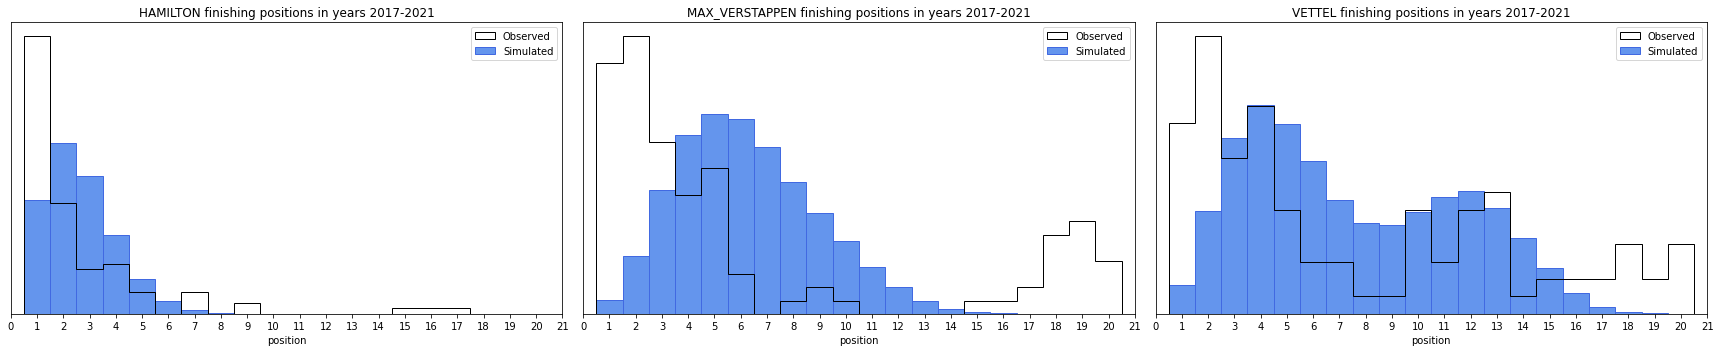

In [17]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# pos_min = 1, pos_max = 20
n_bins = np.arange(22) - 0.5

# year = 2017
# y_lookup_i = years_lookup[year]
drivers_names = ['hamilton', 'max_verstappen', 'vettel']
for d_i, d_name in enumerate(drivers_names):
    d_lookup_i = drivers_lookup[d_name]
    # results = df[(df['driver'] == d_name) & (df['year'] == year)]
    results = df[df['driver'] == d_name]
    axes[d_i].hist((results['position']+1).tolist(), bins=n_bins, rwidth=1, histtype='step', edgecolor='black', density=True, label='Observed')
    results_idx = results.index
    axes[d_i].hist(model_2_fit.stan_variable('y_hat').T[results_idx].flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True, label='Simulated')
    axes[d_i].set_xticks(range(22))
    axes[d_i].set_xlim([0, 21])
    axes[d_i].set_yticks([])
    # axes[d_i].set_title(d_name.upper() + ' ' + str(year))
    axes[d_i].set_title(d_name.upper() + ' finishing positions in years 2017-2021')
    axes[d_i].legend()
    axes[d_i].set_xlabel(r'position')

fig.tight_layout()
plt.show()

## Parameters

### Mean driver skill $\alpha_{d}$ and constructor advantage $\alpha_{c}$ 

As with model 1, if we compare $\alpha_{d}$ for each drivers, it is clearly visible that our model corectly recognize quality of a driver - below we ploted parameters for Hamilton (one of the best drivers), Perez (medium driver at that time) and Stroll (he pays to drive which means that he is realy bad). After calculating mean of all parameters for each driver, Hamilton has lowest, and Stroll has highest parameter alpha (the lower parameter - the better).

Same analysis was conducted for constructors - Mercedes as one of the best constructor has the lowest parameter $\alpha_{c}$ and Haas as one of the worst - the highest.

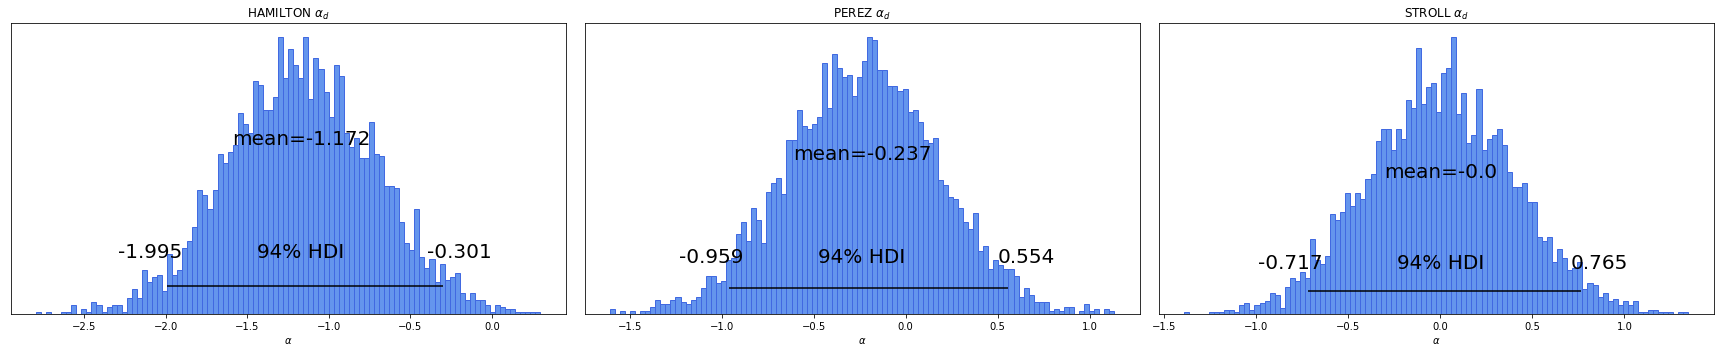

In [18]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

drivers_names = ['hamilton', 'perez', 'stroll']
x = np.linspace(0, 4000, 4000)

statistics = az.summary(model_2_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.94)
for d_i, d_name in enumerate(drivers_names):
    # axes[d_i].scatter(x, model_2_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]], color='royalblue', s=1)
    hdi_l = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'hdi_3%']
    hdi_h = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'hdi_97%']
    mean = statistics.loc[f'alpha_driver[{drivers_lookup[d_name]}]', 'mean']
    axes[d_i].hist(model_2_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]].flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[d_i].hlines(y=0.1, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[d_i].annotate(str(hdi_l), xy=(hdi_l-0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate(str(hdi_h), xy=(hdi_h+0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate('94% HDI', xy=(mean, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].annotate(f'mean={mean}', xy=(mean, 0.6), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[d_i].set_yticks([])
    # axes[d_i].hlines(model_2_fit.stan_variable('alpha_driver').T[drivers_lookup[d_name]].mean(), xmin=0, xmax=4000, color='royalblue', linewidth=2)
    axes[d_i].set_title(d_name.upper() + r' $\alpha_d$')
    axes[d_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

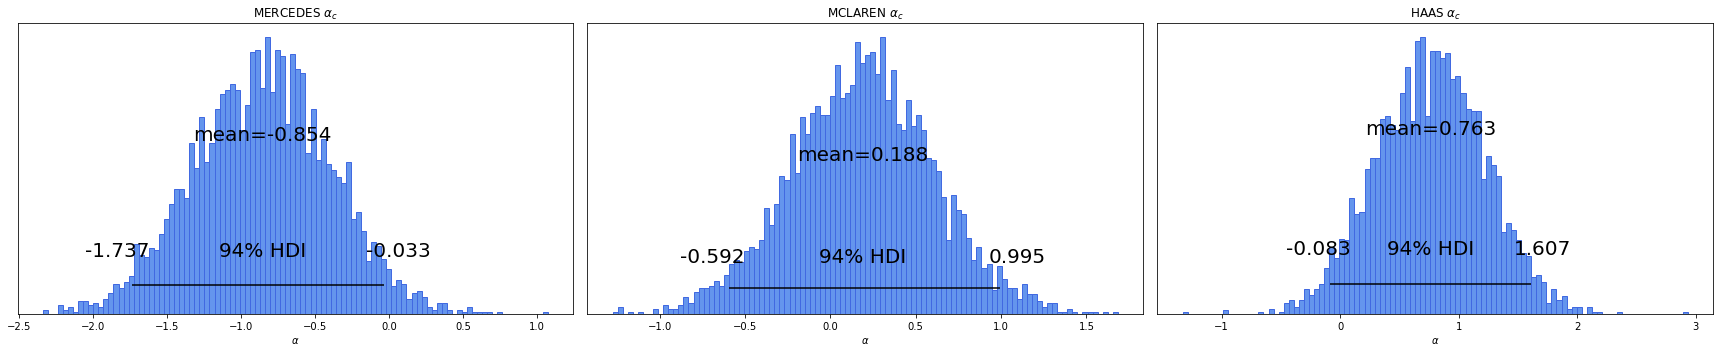

In [19]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

constructors_names = ['mercedes', 'mclaren', 'haas']
x = np.linspace(0, 4000, 4000)

statistics = az.summary(model_2_fit, var_names=['alpha_constructor'], kind='stats', hdi_prob=.94)
for c_i, c_name in enumerate(constructors_names):
    # axes[c_i].scatter(x, model_2_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]], color='royalblue', s=1)
    hdi_l = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'hdi_3%']
    hdi_h = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'hdi_97%']
    mean = statistics.loc[f'alpha_constructor[{constructors_lookup[c_name]}]', 'mean']
    axes[c_i].hist(model_2_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]].flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[c_i].hlines(y=0.1, xmin=hdi_l, xmax=hdi_h, color='black')
    axes[c_i].annotate(str(hdi_l), xy=(hdi_l-0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate(str(hdi_h), xy=(hdi_h+0.1, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate('94% HDI', xy=(mean, 0.2), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].annotate(f'mean={mean}', xy=(mean, 0.6), xycoords='data', fontsize=20, horizontalalignment='center')
    axes[c_i].set_yticks([])
    # axes[c_i].hlines(model_2_fit.stan_variable('alpha_constructor').T[constructors_lookup[c_name]].mean(), xmin=0, xmax=4000, color='royalblue', linewidth=2)
    axes[c_i].set_title(c_name.upper() + r' $\alpha_c$')
    axes[c_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

### Yearly driver skill deviations $\alpha_{d,y}$ and constructor advantage deviations $\alpha_{c,y}$

If we compare $\alpha_{d,y}$ for each drivers, it is clearly visible that our model corectly recognize progression of quality of a driver - below we ploted parameters for Hamilton, Vettel and Stroll. Progression of Verstappen skill is clearly visibile (his worst year was 2017, best - 2021), as well as constant decline of Vettel (best in 2017/18, worst in 2020/21). Stroll performance was rather constant, but our model recognized that 2017 was the best year in his career.

Same analysis was conducted for constructors - rather constant Mercedes advantage (although our model recognized that 2021 was their worse year as they missed out on Drivers Championship), constant improvement of McLaren and constant decline of Haas.

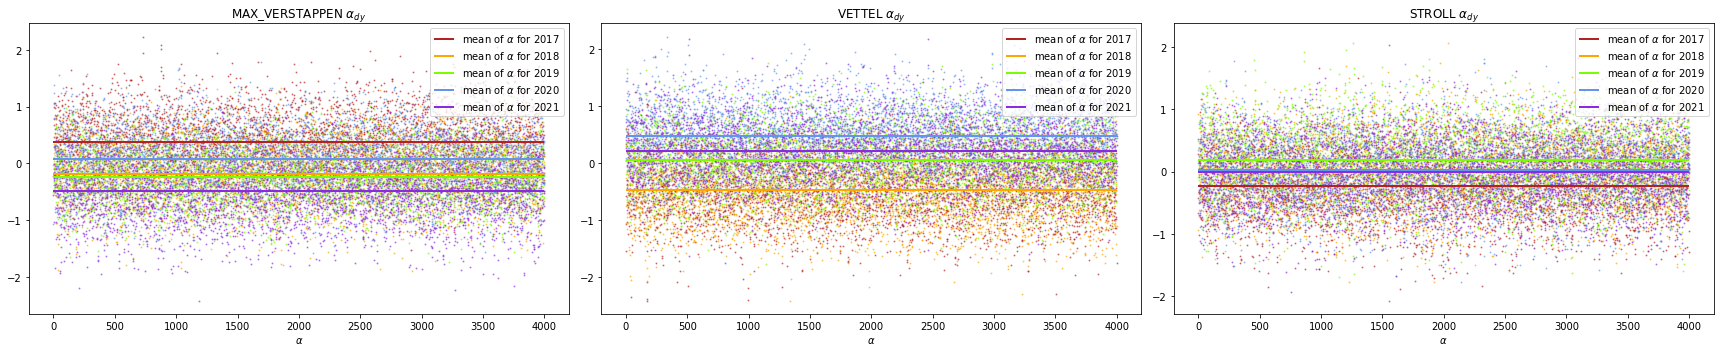

In [20]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

drivers_names = ['max_verstappen', 'vettel', 'stroll']
x = np.linspace(0, 4000, 4000)

colors = ['firebrick', 'orange', 'lawngreen', 'cornflowerblue', 'blueviolet']

for d_i, d_name in enumerate(drivers_names):
    for y_i, y_name in enumerate(['2017', '2018', '2019', '2020', '2021']):
        axes[d_i].scatter(x, model_2_fit.stan_variable('alpha_driver_year').T[drivers_lookup[d_name], y_i], color=colors[y_i], s=1, alpha=0.5)
        axes[d_i].hlines(model_2_fit.stan_variable('alpha_driver_year').T[drivers_lookup[d_name], y_i].mean(), xmin=0, xmax=4000, color=colors[y_i], 
                         label=r'mean of $\alpha$ for ' + y_name, linewidth=2)
    axes[d_i].set_title(d_name.upper() + r' $\alpha_{dy}$')
    axes[d_i].legend(loc='upper right')
    axes[d_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

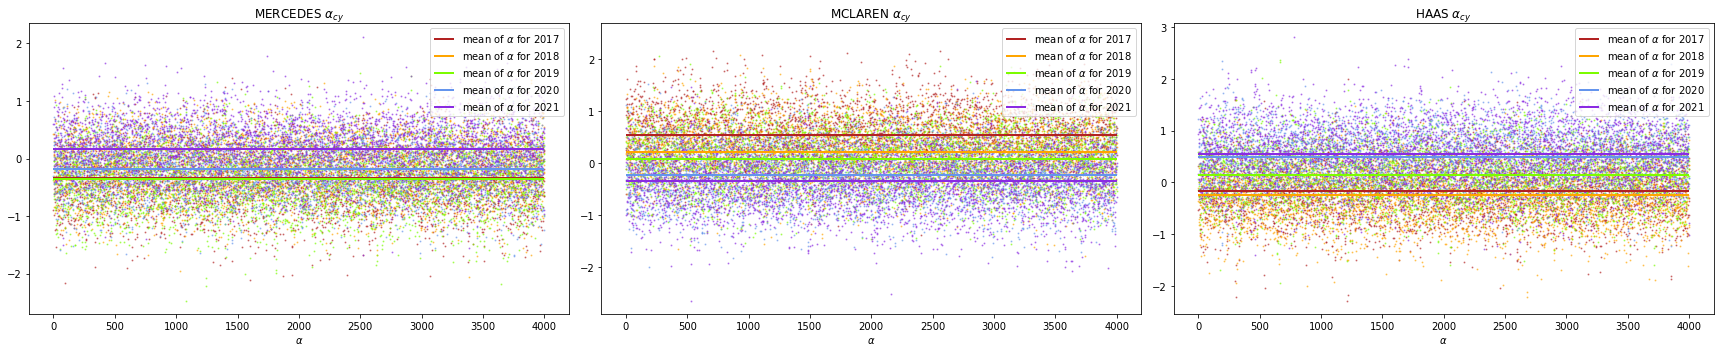

In [21]:
n_rows, n_cols = 1, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

constructors_names = ['mercedes', 'mclaren', 'haas']
x = np.linspace(0, 4000, 4000)

colors = ['firebrick', 'orange', 'lawngreen', 'cornflowerblue', 'blueviolet']

for c_i, c_name in enumerate(constructors_names):
    for y_i, y_name in enumerate(['2017', '2018', '2019', '2020', '2021']):
        axes[c_i].scatter(x, model_2_fit.stan_variable('alpha_constructor_year').T[constructors_lookup[c_name], y_i], color=colors[y_i], s=1, alpha=0.5)
        axes[c_i].hlines(model_2_fit.stan_variable('alpha_constructor_year').T[constructors_lookup[c_name], y_i].mean(), xmin=0, xmax=4000, color=colors[y_i], 
                         label=r'mean of $\alpha$ for ' + y_name, linewidth=2)
    axes[c_i].set_title(c_name.upper() + r' $\alpha_{cy}$')
    axes[c_i].legend(loc='upper right')
    axes[c_i].set_xlabel(r'$\alpha$')

fig.tight_layout()
plt.show()

## Drivers ranking (based on $\alpha_{d}$)

We produced a ranking based on $\alpha_{d}$ parameters estimated by model 2 for each of the drivers.

As expected, Hamilton and Verstappen are ranked as the most skilled drivers.

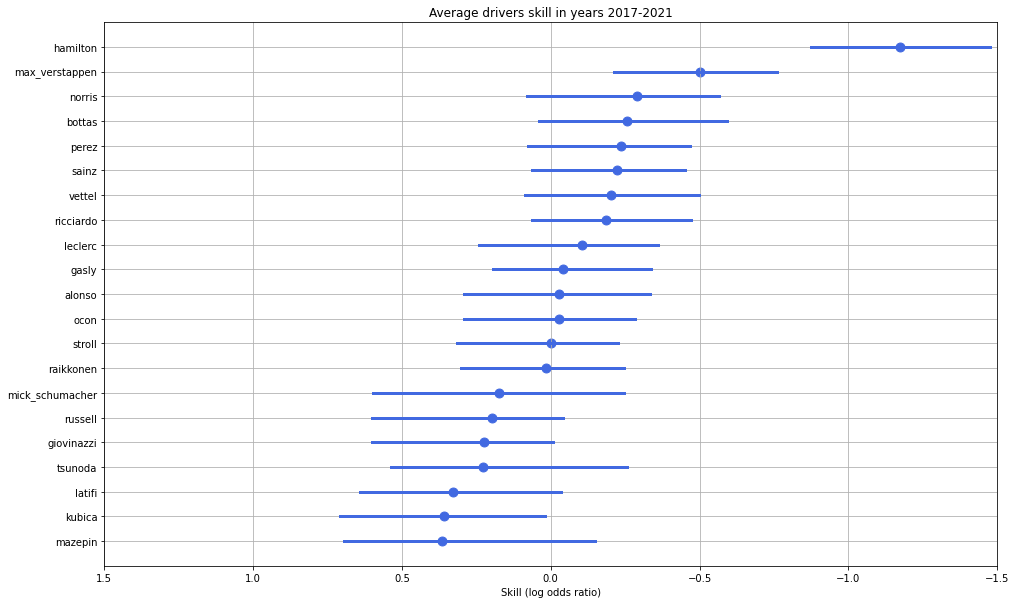

In [22]:
driver = az.summary(model_2_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.50)

cmap = plt.cm.get_cmap('hsv', len(drivers_lookup))

drivers_in_2021 = df[df.loc[:, 'year']==2021]['driver'].unique()

driver['name'] = drivers_lookup.keys()
driver = driver[driver['name'].isin(drivers_in_2021)]
driver = driver.sort_values(by=['mean'])

plt.figure(figsize=(16, 10))

drivers_in_2021 = df[df['year']==2021]['driver'].unique()

for i in drivers_in_2021:
    mean = driver.loc[f'alpha_driver[{drivers_lookup[i]}]', 'mean']
    plt.scatter(mean, 20 - np.where(driver['mean']==mean)[0][0], s=80, color='royalblue')
    hdi_l = driver.loc[f'alpha_driver[{drivers_lookup[i]}]',:][2]
    hdi_h = driver.loc[f'alpha_driver[{drivers_lookup[i]}]',:][3]
    plt.plot([hdi_l, hdi_h], [20 - np.where(driver['mean']==mean)[0][0], 20 - np.where(driver['mean']==mean)[0][0]], linewidth=3, color='royalblue')
# , color=cmap(i)
plt.yticks(range(0, len(drivers_in_2021)), list(driver['name'])[::-1])
plt.xlim((1.5, -1.5))
plt.xlabel('Skill (log odds ratio)')
plt.title('Average drivers skill in years 2017-2021')
plt.grid()
plt.show()

## Constructors rankings (based on $\alpha_{c}$)

We produced a ranking based on $\alpha_{c}$ parameters estimated by model 2 for each of the constructors.

As expected, Mercedes, Ferrari and Red Bull are ranked as the best constructors and Haas, Williams and Alfa Romeo as the worst.

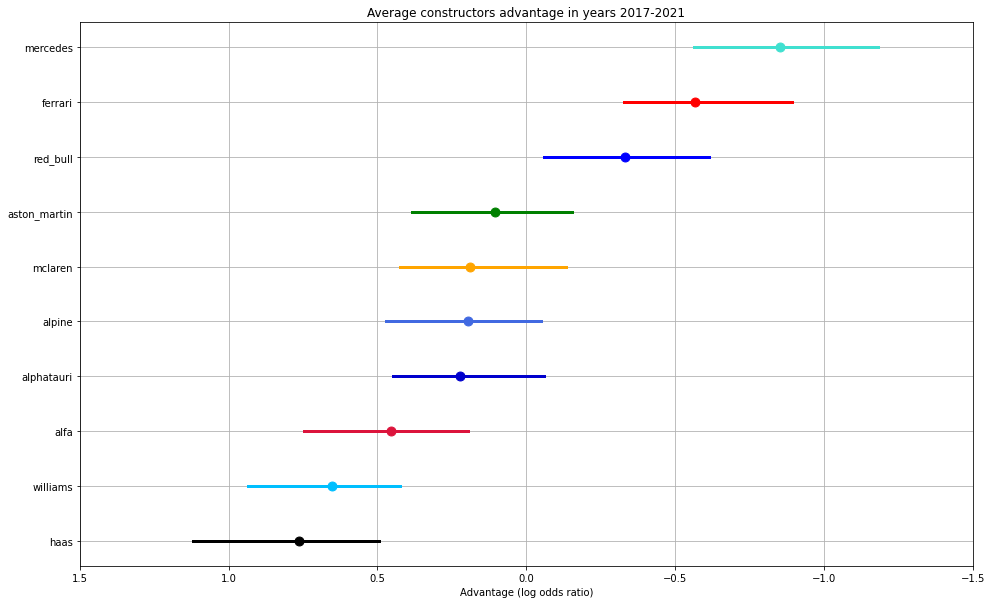

In [23]:
constructor_color = {'ferrari': 'red', 'mercedes': 'turquoise', 'red_bull': 'blue', 
                     'williams': 'deepskyblue', 'aston_martin': 'green', 
                     'alphatauri': 'mediumblue', 'alpine': 'royalblue', 
                     'alfa': 'crimson', 'mclaren': 'orange', 'haas': 'k'}

driver = az.summary(model_2_fit, var_names=['alpha_driver'], kind='stats', hdi_prob=.50)
constructor = az.summary(model_2_fit, var_names=['alpha_constructor'], kind='stats', hdi_prob=.50)


constructor['name'] = constructors_lookup.keys()
constructor = constructor.sort_values(by=['mean'])

plt.figure(figsize=(16, 10))

for i in constructors_lookup.keys():
    mean = constructor.loc[f'alpha_constructor[{constructors_lookup[i]}]', 'mean']
    plt.scatter(mean, 9 - np.where(constructor['mean']==mean)[0][0], color=constructor_color[i], s=80)
    hdi_l = constructor.loc[f'alpha_constructor[{constructors_lookup[i]}]',:][2]
    hdi_h = constructor.loc[f'alpha_constructor[{constructors_lookup[i]}]',:][3]
    plt.plot([hdi_l, hdi_h], [9 - np.where(constructor['mean']==mean)[0][0], 9 - np.where(constructor['mean']==mean)[0][0]], color=constructor_color[i], linewidth=3)

plt.yticks(range(0, 10), list(constructor['name'])[::-1])
plt.xlim((1.5, -1.5))
plt.xlabel('Advantage (log odds ratio)')
plt.title('Average constructors advantage in years 2017-2021')
plt.grid()
plt.show()

## Drivers performance progression (based on $\alpha_{d,y}$)

As our model contains a yearly form parameter, we can also visualize the skill trajectories of several drivers.

In [24]:
def get_driver_in_year(driver_number, df):
    mean = []
    sd = []
    hdi = []
    for i in range(5):
        mean.append(df.loc[f'alpha_driver_year[{i}, {driver_number}]', 'mean'])
        sd.append(df.loc[f'alpha_driver_year[{i}, {driver_number}]', 'sd'])
        hdi.append([df.loc[f'alpha_driver_year[{i}, {driver_number}]'][2], df.loc[f'alpha_driver_year[{i}, {driver_number}]'][3]])
    return mean, sd, np.asarray([hdi]).reshape(5, 2)

def ribbonplot(model_2_fit, driver, df, cmap):
    occ_y = df.loc[df['driver'] == driver].year.unique()
    simulated_years = [2017, 2018, 2019, 2020, 2021]

    a = az.summary(model_2_fit, var_names='alpha_driver_year', kind='stats', hdi_prob=.50)

    mean, sd, hdi = get_driver_in_year(drivers_lookup[driver], a)
    mean_app = []
    driven_years = []
    driven_hdi = []
    for i, y in enumerate(simulated_years):
        if y in occ_y:
            mean_app.append(mean[i])
            driven_years.append(y)
            driven_hdi.append(hdi[i, :])

    driven_hdi = np.asarray([driven_hdi]).reshape(len(driven_hdi), 2)
    # print(np.asarray([hdi]).reshape(5, 2).shape)
    plt.figure(figsize=(8,5))
    plt.title(driver.upper() + ' performance progression')
    plt.grid()

    color = cmap(drivers_lookup[driver])
    az.plot_hdi(x=driven_years, hdi_data=driven_hdi, color=color, smooth=False)
    plt.plot(driven_years, mean_app, linewidth=2, color='k')
    plt.xticks([2017, 2018, 2019, 2020, 2021])
    plt.scatter(occ_y, mean_app, s=70, edgecolors='k', facecolors='k')
    plt.ylim((1.5, -1.5))
    plt.xlim([2017-0.1, 2021+0.1])
    plt.show()

cmap = plt.cm.get_cmap('hsv', len(drivers_lookup))

# drivers_in_2021 = df[df['year']==2021]['driver'].unique()

# for i in drivers_in_2021:
#     ribbonplot(model_2_fit, i, df, cmap)

# plt.tight_layout()

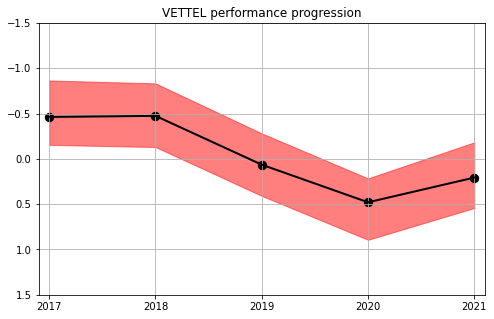

In [25]:
ribbonplot(model_2_fit, 'vettel', df, cmap)
plt.show()

Constant decline of Vettel is once again clearly visible.

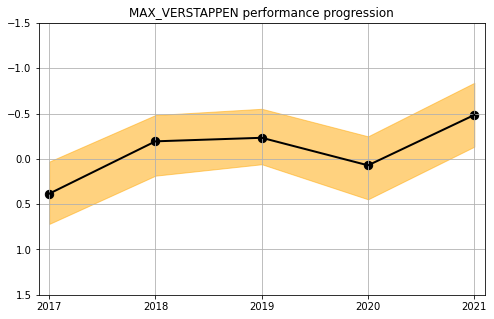

In [26]:
ribbonplot(model_2_fit, 'max_verstappen', df, cmap)
plt.show()

As well as constant development of Verstappen...

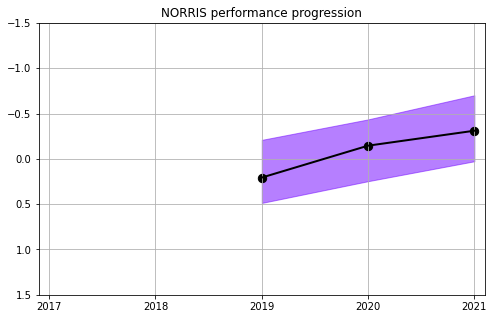

In [27]:
ribbonplot(model_2_fit, 'norris', df, cmap)
plt.show()

...and Norris.

## Constructors performance progression (based on $\alpha_{c, y}$)

As our model contains a yearly form parameter, we can also visualize the advantage trajectories of several constructors.

In [28]:
# az.summary(model_2_fit, var_names='alpha_constructor_year', kind='stats', hdi_prob=.95)

def get_constructor_in_year(constructor_number, df):
    mean = []
    sd = []
    hdi = []
    for i in range(5):
        mean.append(df.loc[f'alpha_constructor_year[{i}, {constructor_number}]', 'mean'])
        sd.append(df.loc[f'alpha_constructor_year[{i}, {constructor_number}]', 'sd'])
        hdi.append([df.loc[f'alpha_constructor_year[{i}, {constructor_number}]'][2], df.loc[f'alpha_constructor_year[{i}, {constructor_number}]'][3]])
    return mean, sd, np.asarray([hdi]).reshape(5, 2)

def ribbonplot(model_2_fit, constructor, df):
    occ_y = df.loc[df['constructor'] == constructor].year.unique()
    simulated_years = [2017, 2018, 2019, 2020, 2021]

    a = az.summary(model_2_fit, var_names='alpha_constructor_year', kind='stats', hdi_prob=.50)

    mean, sd, hdi = get_constructor_in_year(constructors_lookup[constructor], a)
    # print(np.asarray([hdi]).reshape(5, 2).shape)
    plt.figure(figsize=(8,5))
    plt.title('Performance ' + constructor.upper())
    plt.grid()
    color = constructor_color[constructor]
    az.plot_hdi(x=simulated_years, hdi_data=hdi, color=color, smooth=False)
    plt.plot(simulated_years, mean, linewidth=2, color='k')
    plt.xticks([2017, 2018, 2019, 2020, 2021])
    plt.scatter(simulated_years, mean, s=70, color='k')
    plt.ylim((1.5, -1.5))
    plt.xlim([2017-0.1, 2021+0.1])
    plt.show()

# for i in constructors_lookup.keys():
#     ribbonplot(model_2_fit, i, df)

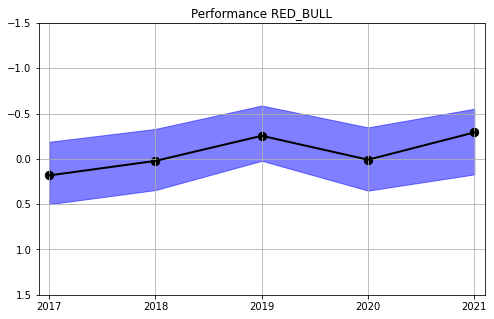

In [29]:
ribbonplot(model_2_fit, 'red_bull', df)
plt.show()

Development of Red Bull is clearly visible...

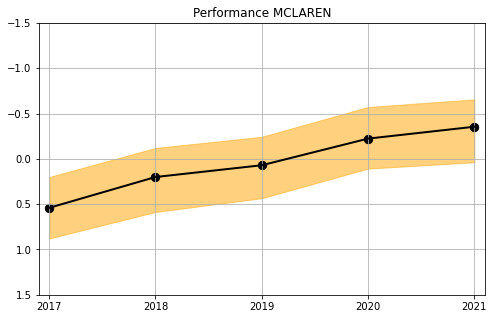

In [30]:
ribbonplot(model_2_fit, 'mclaren', df)
plt.show()

...as well as McLaren's...

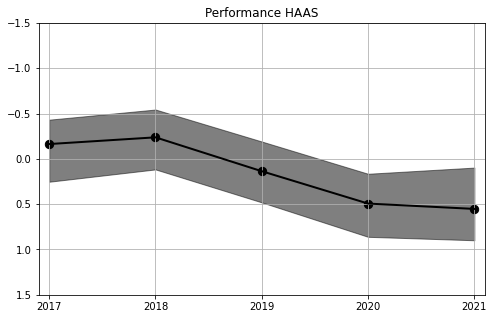

In [31]:
ribbonplot(model_2_fit, 'haas', df)
plt.show()

...and constant decline of Haas.

---
# Model comparison

Model comaprison [0-4 pts]
  - Have models been compared using information criteria [1 pt]
  - Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
  - Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
  - Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

In [32]:
fit_1 = az.from_cmdstanpy(posterior=model_1_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_1_data['position'])

fit_2 = az.from_cmdstanpy(posterior=model_2_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_2_data['position'])

## WAIC criterion

c:\Users\Konrad\anaconda3\envs\data_analytics_env\lib\site-packages\arviz\stats\stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Konrad\anaconda3\envs\data_analytics_env\lib\site-packages\arviz\stats\stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


                     rank         waic      p_waic      d_waic   weight  \
Model 2 (d+c+dy+cy)     0 -8126.692808  488.993245    0.000000  0.60918   
Model 1 (d+c)           1 -8318.486431  177.536630  191.793623  0.39082   

                             se        dse  warning waic_scale  
Model 2 (d+c+dy+cy)  180.157756   0.000000     True        log  
Model 1 (d+c)        174.458069  69.679101     True        log  


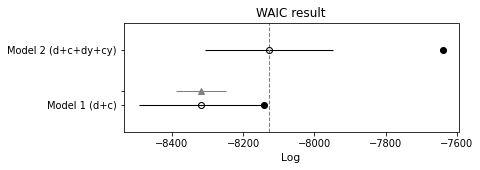

In [33]:
compare_dict = {'Model 1 (d+c)': fit_1, 'Model 2 (d+c+dy+cy)': fit_2}

waic_compare = az.compare(compare_dict, ic='waic')
print(waic_compare)
az.plot_compare(waic_compare)
plt.title('WAIC result')
plt.show()

Model 2 (which takes into account yearly deviations of form) was recognized as the best model (lowest rank in *rank* column and higher relative weight in *weight* column), as it has higher out-of-sample predictive fit (*waic* column).
Model 2 has higher estimated effective number of parameters (*p_waic* column). 
Both models has similar standard error of the WAIC estimate (*se* column).
Standard error of the difference between the two models is small (overlap).

Warning occured for both of the models indicating that WAIC computation may not be reliable. This is probably due to the large number of parameters of both of the models.

The filled points are the in-sample log values. The open points are the WAIC values (*waic* column in table above). Naturally, each model does better in-sample than it is expected to do out-of-sample. The line segments show the standard error of each WAIC (*se* column in table above). Standard error of the difference in WAIC between the two models is shown by lighter line segment with the triangle on it (*dse* column in table above).

## PSIS-LOO criterion

c:\Users\Konrad\anaconda3\envs\data_analytics_env\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Konrad\anaconda3\envs\data_analytics_env\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


                     rank          loo       p_loo       d_loo    weight  \
Model 2 (d+c+dy+cy)     0 -8130.731620  493.032058    0.000000  0.607995   
Model 1 (d+c)           1 -8319.382067  178.432266  188.650447  0.392005   

                             se        dse  warning loo_scale  
Model 2 (d+c+dy+cy)  180.267819   0.000000     True       log  
Model 1 (d+c)        174.457216  69.730378     True       log  


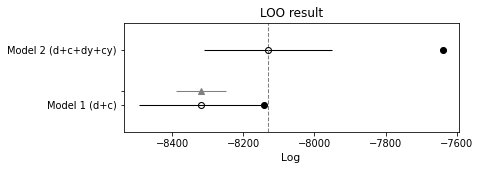

In [34]:
loo_compare = az.compare(compare_dict, ic='loo')
print(loo_compare)
az.plot_compare(loo_compare)
plt.title('LOO result')
plt.show()

Model 2 (which takes into account yearly deviations of form) was recognized as the best model (lowest rank in *rank* column and higher relative weight in *weight* column), as it has higher out-of-sample predictive fit (*loo* column).
Model 2 has higher estimated effective number of parameters (*p_loo* column). 
Both models has similar standard error of the LOO estimate (*se* column).
Standard error of the difference between the two models is small (overlap).

Warning occured for both of the models indicating that LOO computation may not be reliable. This is probably due to the large number of parameters of both of the models.

The filled points are the in-sample log values. The open points are the LOO values (*loo* column in table above). Naturally, each model does better in-sample than it is expected to do out-of-sample. The line segments show the standard error of each LOO (*se* column in table above). Standard error of the difference in LOO between the two models is shown by lighter line segment with the triangle on it (*dse* column in table above).

## Summary

For both information criterias we obtained similar results confirming what was expected - more complicated model performs better, as it can represent form of both driver and constructor in each year separately.

---
# Prediction

Using samples from the posterior distributions of the parameters we can compare the predicted outcome (finishing position) for different configurations of the predictors.

## Prediction 1 - Russell in Mercedes in 2021

After 2021 season George Russell moved from Williams to Mercedes. Using one of our models we will try to predict what could have happened, if Russell had made the move a year earlier.

In [35]:
model_2_prediction = CmdStanModel(stan_file='stan/model_2_prediction.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)



chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)


chain 1 |█▊        | 00:01 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██▎       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)
chain 1 |██▋       | 00:02 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |███▏      | 00:02 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |███▋      | 00:03 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████      | 00:03 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |████▌     | 00:04 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |█████     | 00:04 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 00:04 Sampling completed                      
chain 2 |██████████| 00:04 Sampling completed                      
chain 3 |██████████| 00:04 Sampling completed                      
chain 4 |██████████|


INFO:cmdstanpy:CmdStan done processing.


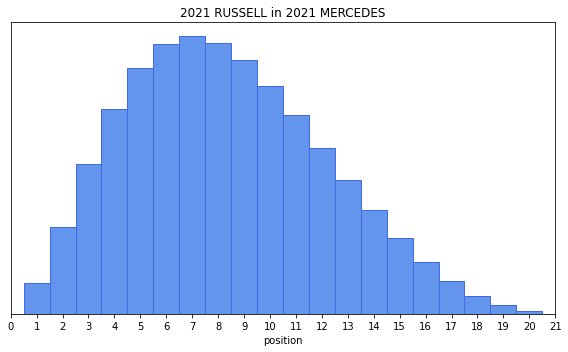

In [36]:
results = model_2_fit.draws_pd()

d_name = 'russell'
c_name = 'mercedes'
d_y_int = 2021
c_y_int = 2021

driver_idx = drivers_lookup[d_name]
constructor_idx = constructors_lookup[c_name]
driver_year_idx = years_lookup[d_y_int]
constructor_year_idx = years_lookup[c_y_int]

model_2_prediction_data = {'N': len(results),
                           'alpha_driver': results[f'alpha_driver[{int(driver_idx)+1}]'],
                           'alpha_constructor': results[f'alpha_constructor[{int(constructor_idx)+1}]'] ,
                           'alpha_driver_year': results[f'alpha_driver_year[{int(driver_year_idx)+1},{int(driver_idx)+1}]'],
                           'alpha_constructor_year': results[f'alpha_constructor_year[{int(constructor_year_idx)+1},{int(constructor_idx)+1}]']}

model_2_prediction_fit = model_2_prediction.sample(data=model_2_prediction_data, seed=12062022)

n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# pos_min = 1, pos_max = 20
n_bins = np.arange(22) - 0.5

ax.hist(model_2_prediction_fit.stan_variable('y_hat').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True, alpha=1)
ax.set_xticks(range(22))
ax.set_xlim([0, 21])
ax.set_yticks([])
ax.set_title(f'{d_y_int} {d_name.upper()} in {c_y_int} {c_name.upper()}')
ax.set_xlabel(r'position')

fig.tight_layout()
plt.show()

## Prediction 2 - 2020 Hamilton in 2021 Haas - the best driver in the worst car

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)


chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)




chain 1 |█▊        | 00:01 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██▎       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |██▋       | 00:02 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |███▏      | 00:02 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |███▋      | 00:02 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████      | 00:03 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |████▌     | 00:03 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |█████     | 00:04 Iteration: 900 / 1000 [ 90%]  (Sampling)
chain 1 |██████████| 00:04 Sampling completed                      
chain 2 |██████████| 00:04 Sampling completed                      
chain 3 |██████████| 00:04 Sampling completed                      


chain 4 |█████████


INFO:cmdstanpy:CmdStan done processing.


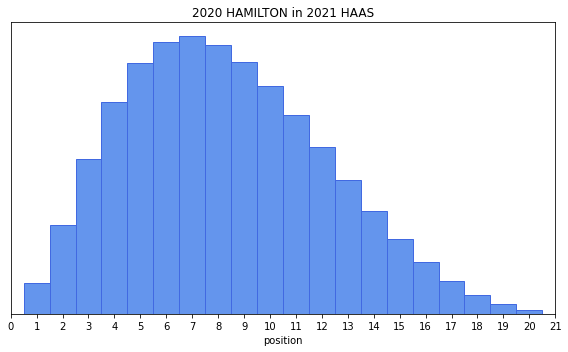

In [37]:
results = model_2_fit.draws_pd()

d_name = 'hamilton'
c_name = 'haas'
d_y_int = 2020
c_y_int = 2021

driver_idx = drivers_lookup[d_name]
constructor_idx = constructors_lookup[c_name]
driver_year_idx = years_lookup[d_y_int]
constructor_year_idx = years_lookup[c_y_int]

model_2_prediction_data = {'N': len(results),
                           'alpha_driver': results[f'alpha_driver[{int(driver_idx)+1}]'],
                           'alpha_constructor': results[f'alpha_constructor[{int(constructor_idx)+1}]'] ,
                           'alpha_driver_year': results[f'alpha_driver_year[{int(driver_year_idx)+1},{int(driver_idx)+1}]'],
                           'alpha_constructor_year': results[f'alpha_constructor_year[{int(constructor_year_idx)+1},{int(constructor_idx)+1}]']}

model_2_prediction_fit = model_2_prediction.sample(data=model_2_prediction_data, seed=12062022)

n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 5*n_rows))

# pos_min = 1, pos_max = 20
n_bins = np.arange(22) - 0.5

ax.hist(model_2_prediction_fit.stan_variable('y_hat').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True, alpha=1)
ax.set_xticks(range(22))
ax.set_xlim([0, 21])
ax.set_yticks([])
ax.set_title(f'{d_y_int} {d_name.upper()} in {c_y_int} {c_name.upper()}')
ax.set_xlabel(r'position')

fig.tight_layout()
plt.show()